# King County Housing Price Predictive Model

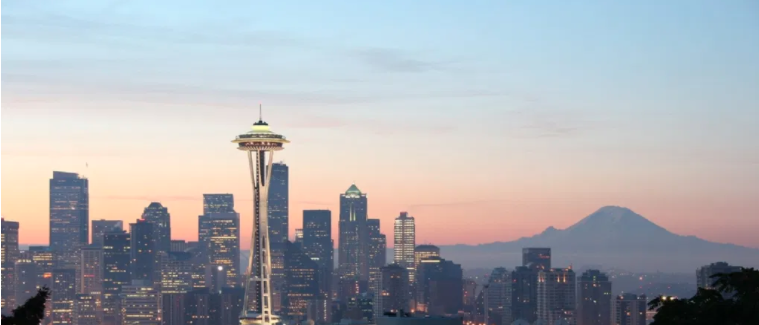

## Overview

Given a set of data about the housing market in King County, Washington by the Flatiron School, NYC, the task to perform was to create the best predictive model for a house's sale price. My goal was to take the 17,000+ rows of data and break them up into a set of training data and testing data to find the best performing model based on the lowest RMSE. I would then aggregate all the data to train my best performing model on, to then put it to one final test on a set of holdout data with no price column. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
import random

from statsmodels.formula.api import ols
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, RFECV

pd.pandas.set_option('display.max_columns', None)

## Read in Data

In [2]:
data = pd.read_csv('kc_house_data_train.csv')
data.drop(columns=['Unnamed: 0', 'id'], inplace=True)

In [3]:
print(data.shape)
print(data.columns)

(17290, 20)
Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [4]:
data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050


## Exploratory Data Analysis, Statistical Tests, and Feature Engineering

### Some statistical tests to start exploring our data
Based on the data I've been given, I used a few 2-sample T-tests to check some assumptions I had about what makes a house sell for more. Four of those factors included in the dataset are 1) whether time of year affects sale prices 2) whether a house is on the waterfront or not, 3) what the house's grade is based on King County's grading scale, and 4) what condition the house is in overall on a scale of 1-5.

One of my first hunches was that time of year might impact how much a house tends to sell for, but looking at monthly and quarterly means I didn't feel further analysis in that direction was warranted.

In [5]:
# added a new column slicing the month from the 'date' column
data['month_sold'] = data['date'].apply(lambda x: int(x[4:6]))
# added 4 new columns using the new 'month_sold' column to make quarterly dummy columns
data['sold_Q1'] = np.where((data['month_sold'] == 1)|(data['month_sold'] == 2)|(data['month_sold'] == 3), 1, 0)
data['sold_Q2'] = np.where((data['month_sold'] == 4)|(data['month_sold'] == 5)|(data['month_sold'] == 6), 1, 0)
data['sold_Q3'] = np.where((data['month_sold'] == 7)|(data['month_sold'] == 8)|(data['month_sold'] == 9), 1, 0)
data['sold_Q4'] = np.where((data['month_sold'] == 10)|(data['month_sold'] == 11)|(data['month_sold'] == 12), 1, 0)

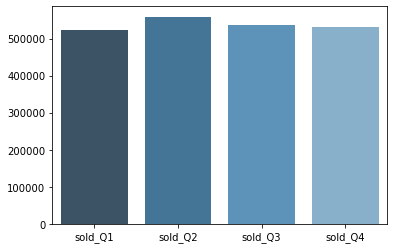

In [6]:
# created barplot comparing average sale prices by quarter
quarters = ['sold_Q1', 'sold_Q2', 'sold_Q3', 'sold_Q4']
quarterly_means = []
for quarter in quarters:
    df = data.loc[data[quarter] == 1]
    quarterly_means.append(round(df['price'].mean(), 2))

sns.barplot(x=quarters, y=quarterly_means, palette="Blues_d")

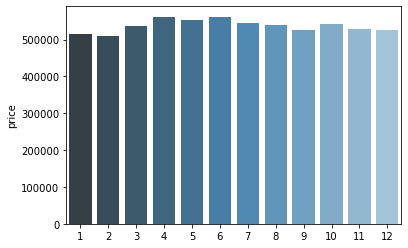

In [7]:
months = list(range(1,13))
monthly_means = data.groupby('month_sold').price.mean()
sns.barplot(x=months, y=monthly_means, palette="Blues_d")

**2 Sample T-test Comparing Waterfront**

Null Hypothesis: The mean sale prices of homes on and off the water are equal

Alternative: The mean of waterfront home prices are on average higher

In [8]:
# taking an initial look at the difference in means in our dataset
data.groupby('waterfront')['price'].mean()

waterfront
0    5.315051e+05
1    1.688486e+06
Name: price, dtype: float64

In [9]:
# separating homes on the water from those not on the water
on_the_water = data[data['waterfront'] == 1]
not_on_water = data[data['waterfront'] == 0]

In [10]:
# taking our random samples
sample1 = not_on_water['price'].sample(n=100)
sample2 = on_the_water['price'].sample(n=100)

In [11]:
stats.ttest_ind(sample1, sample2)

Ttest_indResult(statistic=-8.748650040815741, pvalue=9.398186913415219e-16)

**2 Sample T-test Comparing Homes by their King County Grade (grades are given 1-13)**

Null Hypothesis: On average, homes' grades are not indicative of their sale price

Alternative: On average, homes with a higher score are valued higher on price

In [12]:
# I split the graded homes in half, saying anything higher than 7 is a high score
high_grade = data[data['grade'] > 7]
low_grade = data[data['grade'] <= 7]

In [13]:
sample1 = high_grade['price'].sample(n=100)
sample2 = low_grade['price'].sample(n=100)

In [14]:
stats.ttest_ind(sample1, sample2)

Ttest_indResult(statistic=8.469867295474634, pvalue=5.512281691732201e-15)

**2 Sample T-test Comparing Homes by their Condition (1-5 scale)**

Null Hypothesis: On average, a home's condition is not indicative of its sale price

Alternative: On average, homes in better condition are valued higher

In [15]:
good_condition = data[data['condition'] >= 3]
bad_condition = data[data['condition'] < 3]

In [16]:
sample1 = good_condition['price'].sample(n=100)
sample2 = bad_condition['price'].sample(n=100)

In [17]:
stats.ttest_ind(sample1, sample2)

Ttest_indResult(statistic=5.264782976881506, pvalue=3.638645245370964e-07)

**Based on our results**, it appears 3/3 of my assumptions were correct. Waterfront, grade, and overall condition all claimed enough statistical significance to reject the null hypotheses, and all three factors will help us predict price ultimately.

### Looking at our data

In [18]:
data['yr_sold'] = data['date'].apply(lambda x: int(x[:4]))
data['yr_since_reno'] = data['yr_sold'] - data['yr_renovated']

In [19]:
year_feature = [feature for feature in data.columns if 'yr' in feature]

Text(0.5, 1.0, 'House Price vs. Year Built')

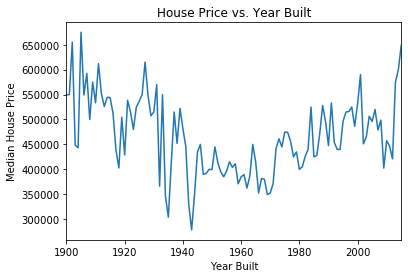

In [20]:
data.groupby('yr_built')['price'].median().plot()
plt.xlabel('Year Built')
plt.ylabel('Median House Price')
plt.title('House Price vs. Year Built')

Looking at the graph above, it has a bit of a "v-shape", telling me that houses built earlier on in the 20th century have likely been renovated, increasing their value again. Houses built around the 1960s have the lowest median sale price, and then as we get closer to 2020, the median progressively rises, indicating that newer houses tend to be worth more.

(1930, 2015.0)

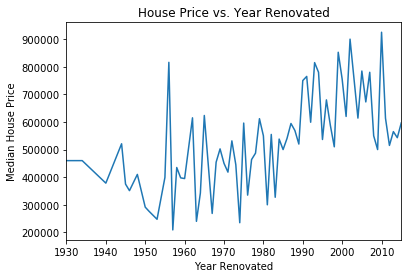

In [21]:
data.groupby('yr_renovated')['price'].median().plot()
plt.xlabel('Year Renovated')
plt.ylabel('Median House Price')
plt.title('House Price vs. Year Renovated')
plt.xlim(left=1930)

Looking at this graph, this supports the graph just above showing us that the more recently a house was renovated, the more likely its price point will be higher.

### Barplots of Categorical Variables

In [22]:
# I've tried to group my features into categorical and continuous groups
# here I've made a list of my discrete features, choosing 31 as my cutoff
# for unique values as there are 30 unique bathroom values
discrete_feature = [feature for feature in data.columns if len(data[feature].unique())<31 and feature not in year_feature+['id']]

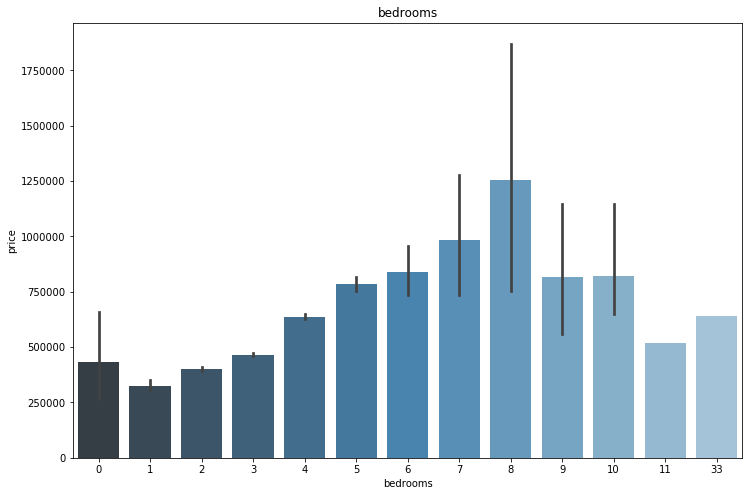

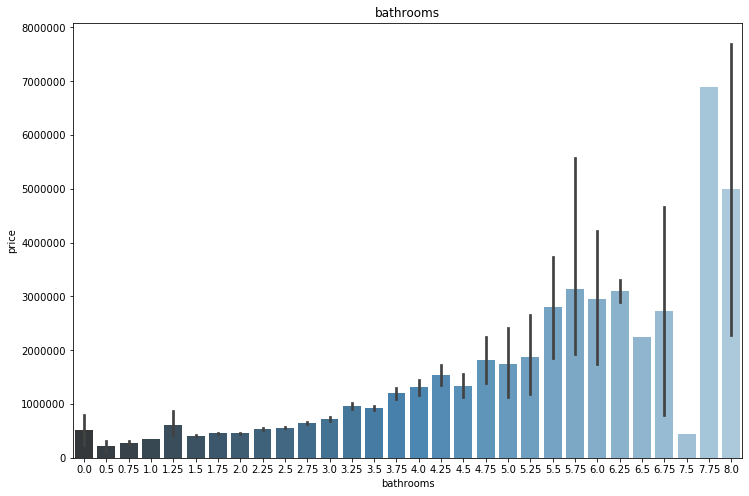

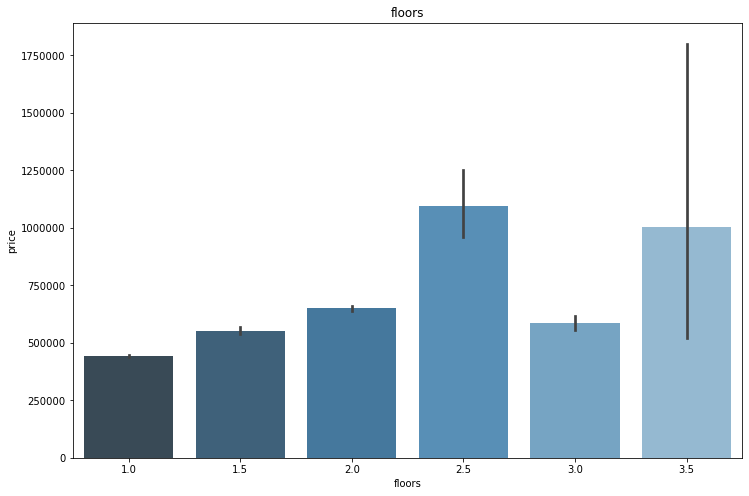

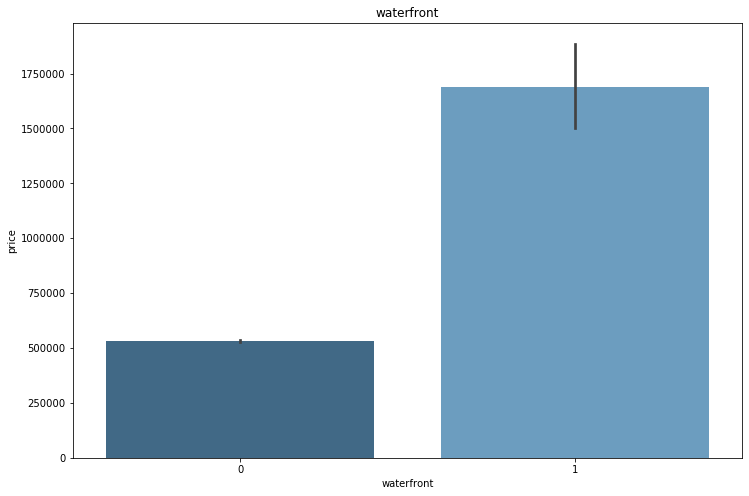

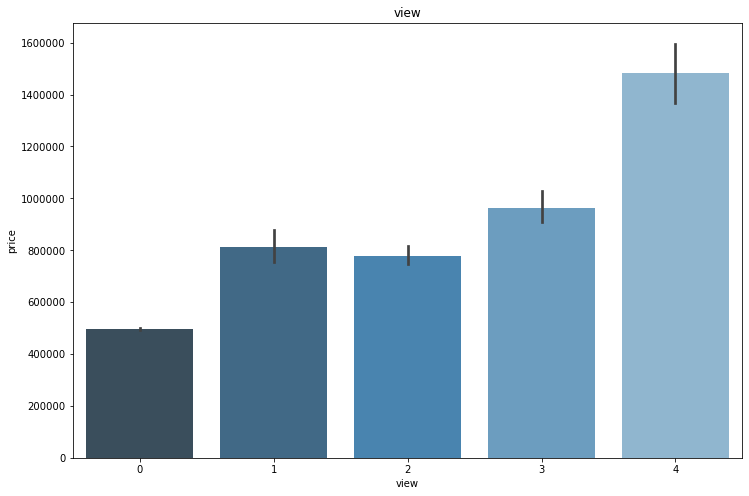

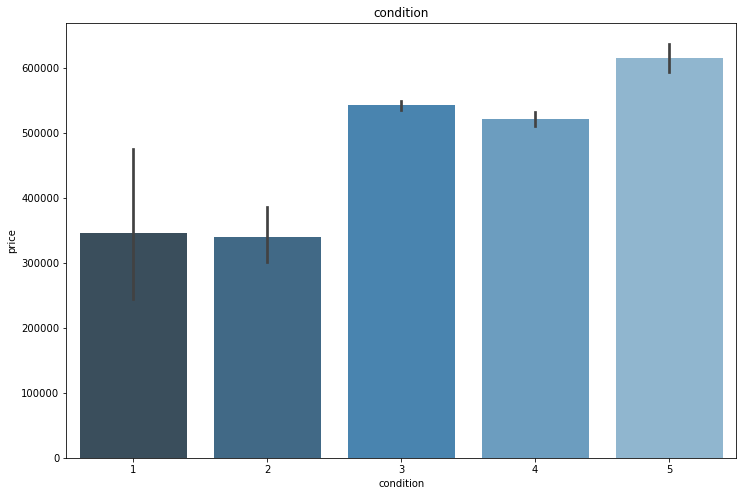

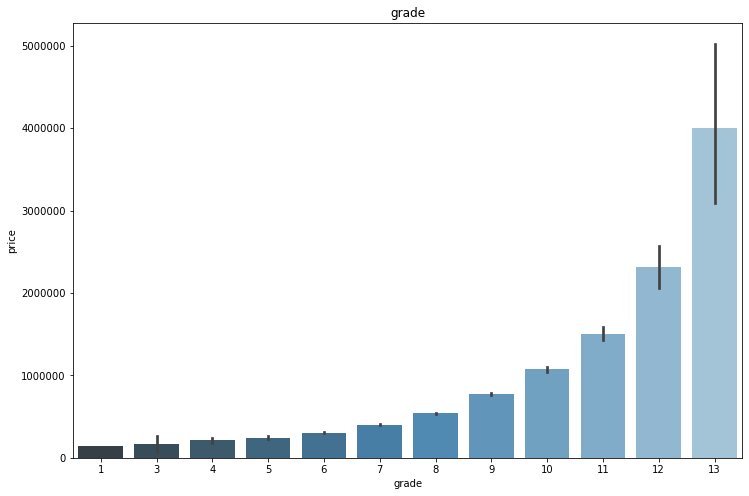

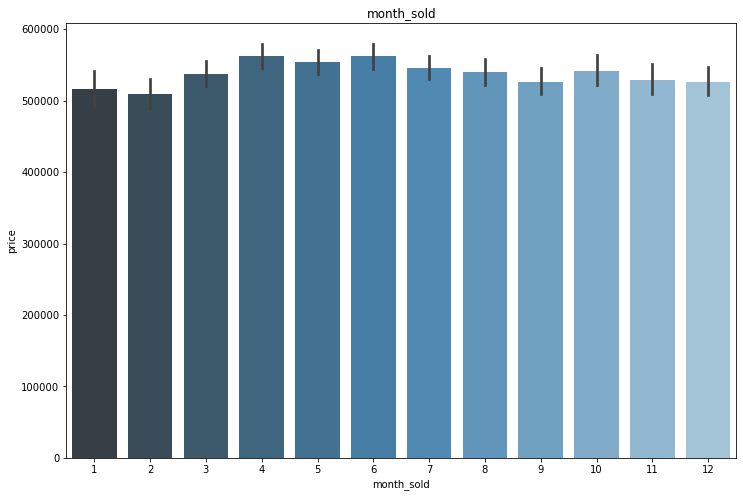

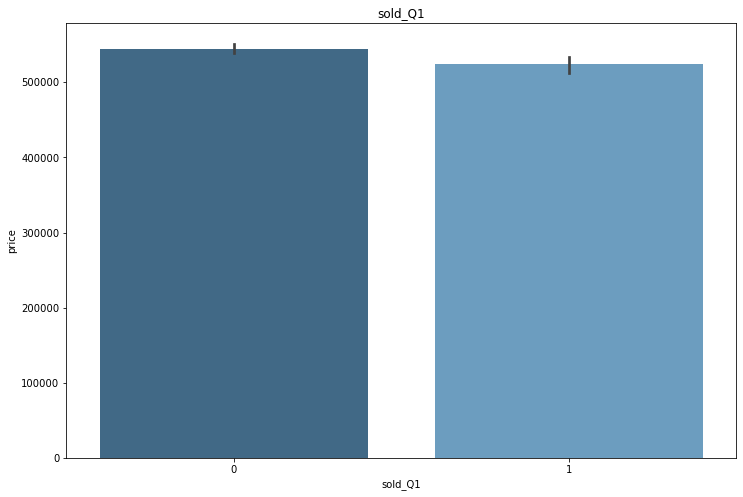

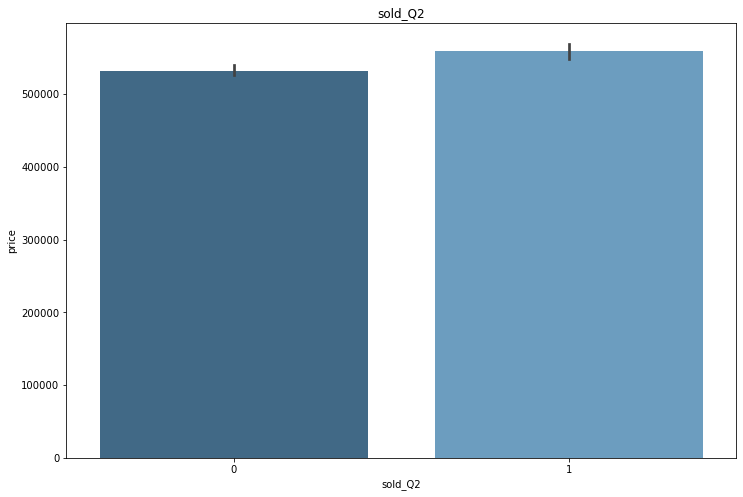

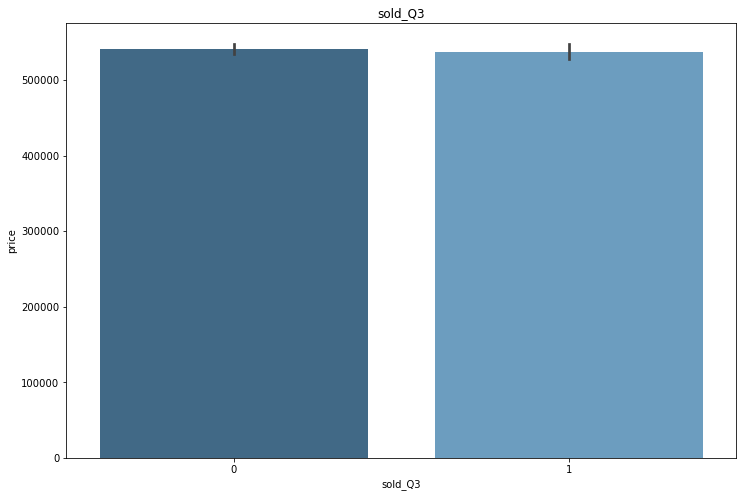

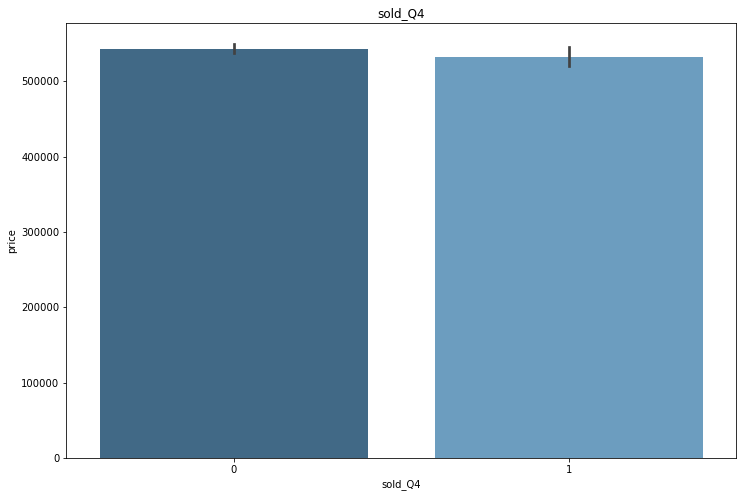

In [23]:
for feature in discrete_feature:
    df = data.copy()
    plt.figure(figsize=(12,8))
    sns.barplot(x=feature, y='price', data=df, palette='Blues_d').set_title(feature)

In [24]:
# adding zipcode because it has a lot of distinct values, but should still
# be considered categorical
discrete_feature.append('zipcode')

### Distributions of Continuous Variables

In [25]:
continuous_feature = [feature for feature in data.columns if feature not in year_feature+discrete_feature+['price']+['date']]

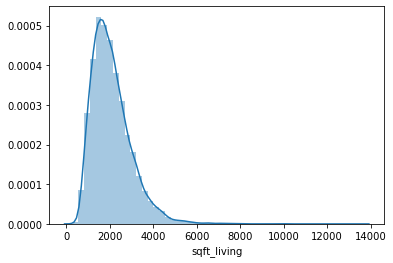

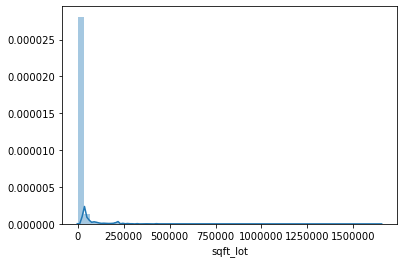

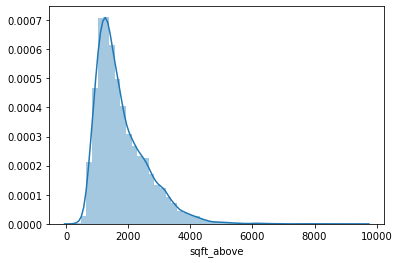

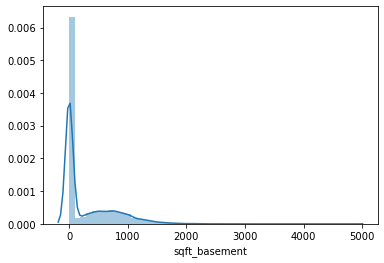

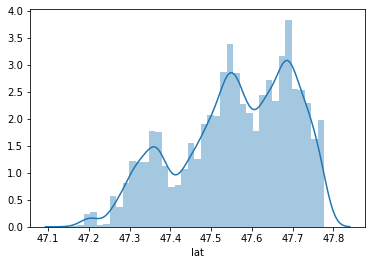

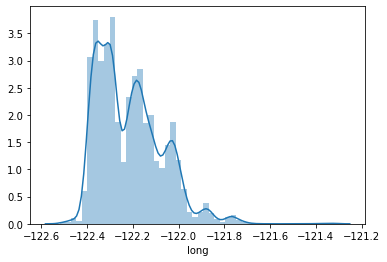

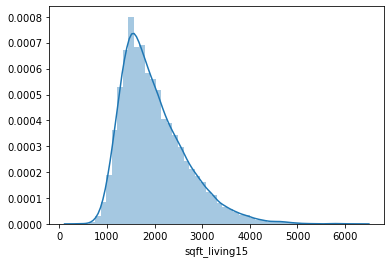

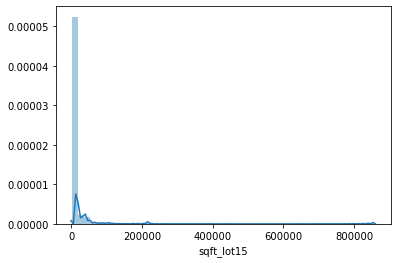

In [26]:
for feature in continuous_feature:
    df = data.copy()
    plt.figure()
    sns.distplot(data[feature])

With the exception of latitude and longitude, it looks like all of our continuous variables are fairly normally distributed but with consistent right skew. I tried log transformations on these in one of my other exploratory notebooks, but it did not seem to improve the model.

### Checking for Multicollinearity Between Features

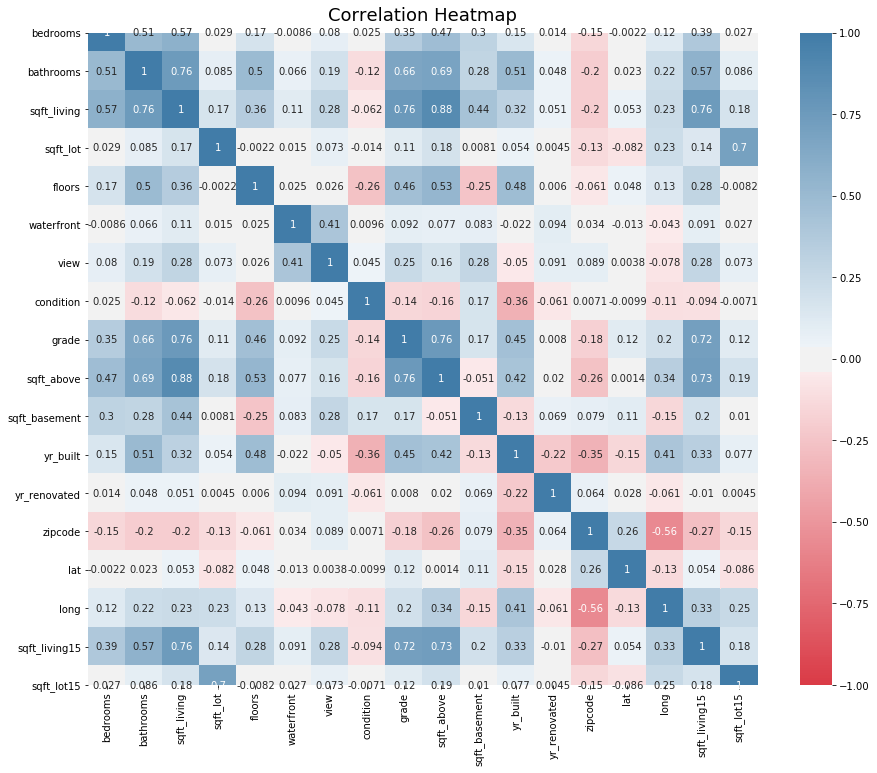

In [27]:
features = ['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15']
cmap = sns.diverging_palette(10, 240, as_cmap=True)
plt.figure(figsize=(15, 12))
heatmap = sns.heatmap(data[features].corr(), vmin=-1, vmax=1, annot=True, cmap=cmap)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

Looking at a correlation heatmap of our baseline features, it's safe to say none of our original features appear too correlated to create any problems of multicollinearity. The extremes are at the poles represented by the darker, more saturated colors here.

## Setup train_test_split and Test Models

### Baseline Model

In [28]:
# using our original features to setup a baseline model
features = ['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'yr_sold', 'yr_since_reno',
       'month_sold']
df_features = data[features]
target = data['price']

# using the default 75/25 train test split, and setting random_state to 88
X_train, X_test, y_train, y_test = train_test_split(df_features, target, random_state=88)

In [29]:
baseline = LinearRegression()
baseline = baseline.fit(X_train, y_train)
y_train_pred = baseline.predict(X_train)
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
print('Baseline Model Training RMSE: ', train_rmse)

Baseline Model Training RMSE:  208058.1308817998


In [30]:
y_test_pred = baseline.predict(X_test)
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
print('Baseline Model Test RMSE: ', test_rmse)

Baseline Model Test RMSE:  194398.76892519553


Surprisingly our baseline model performed better on our test set than on our training set

In [31]:
metrics.r2_score(y_test, y_test_pred)

0.6974445894340897

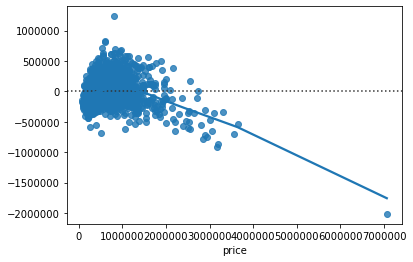

In [32]:
sns.residplot(y_test, y_test_pred,lowess=True)

This scatterplot of residuals from our baseline model shows that our errors are not very homoscedastic violating our assumption of linear regression. I'll try to improve this below while improving my RMSE and R^2 score.

### Log Model

In [33]:
y_log = np.log(y_train)
lr_log = LinearRegression()
lr_log = lr_log.fit(X_train, y_log)
log_train_pred = lr_log.predict(X_train)

In [34]:
y_train_pred = np.exp(log_train_pred)

In [35]:
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, log_train_pred))
print('Log Model Training RMSE: ', train_rmse)

Log Model Training RMSE:  661691.7321091507


In [36]:
log_test_pred = lr_log.predict(X_test)
log_test_pred = np.exp(log_test_pred)
log_test_rmse = np.sqrt(metrics.mean_squared_error(y_test, log_test_pred))
print('Log Model Test RMSE: ', log_test_rmse)

Log Model Test RMSE:  173425.13807983525


Again, our model performed better on the test set than on the train set, this time significantly. Our log test RMSE is our better than our baseline model.

### 2nd Degree Polynomial Model

In [37]:
poly_2 = PolynomialFeatures(degree=2, include_bias=False)
poly2_data = poly_2.fit_transform(df_features)
poly2_columns = poly_2.get_feature_names(df_features.columns)
df_poly2 = pd.DataFrame(poly2_data, columns=poly2_columns)
df_poly2.shape

(17290, 252)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(df_poly2, target, random_state=88)

In [39]:
lr_poly = LinearRegression()
lr_poly = lr_poly.fit(X_train, y_train)
y_train_pred = lr_poly.predict(X_train)
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
print('Poly Model Training RMSE: ', train_rmse)

Poly Model Training RMSE:  152919.39691163896


In [40]:
y_pred = lr_poly.predict(X_test)
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Poly Model Test RMSE: ', test_rmse)

Poly Model Test RMSE:  151685.76590472722


In [41]:
df_poly2.shape

(17290, 252)

Once again our model performed better on the test than on the train, and we have our new low score for RMSE with our 2nd degree polynomial model. Based on the models I was able to create in my exploratory phase, this was the best one I came up with.

## Feature Selection

After trying out different feature selection methods like Kbest and RFE, neither of them really improved nor simplified my model, my best model ended up being a complex, uninterpretable "black box." I opted to leave what I had in there for my optimal model.

## Final Model and Pickling for Holdout Set

In [42]:
import pickle

pickle_out = open("model.pickle","wb")
pickle.dump(lr_poly, pickle_out)
pickle_out.close()

## Conclusions & Next Steps

In the end, I was able to create a better model than my baseline model by creating a bunch of polynomial and interactive features, but it is not interpretable in terms of the coefficients.

Given more time I would have liked to explore more with feature engineering and creating different columns of dummy features as well as diving deeper into the location data. In my exploration I was able to create a very crude map with geopandas, but there is a lot more to explore there especially if I was able to scrape more data based around lat, long, and zipcode.